In [1]:
from __future__ import print_function
#%matplotlib inline
import argparse
import os
import random
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms
from torchvision import models
import torchvision.utils as vutils
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML

# Set random seed for reproducibility
manualSeed = 999
#manualSeed = random.randint(1, 10000) # use if you want new results
print("Random Seed: ", manualSeed)
random.seed(manualSeed)
torch.manual_seed(manualSeed)


import os
import yaml
import argparse
import numpy as np
from pathlib import Path
from models import *
from experiment import VAEXperiment
import torch.backends.cudnn as cudnn
from pytorch_lightning import Trainer
from pytorch_lightning.loggers import TensorBoardLogger
from pytorch_lightning.utilities.seed import seed_everything
from pytorch_lightning.callbacks import LearningRateMonitor, ModelCheckpoint
from dataset import VAEDataset
from pytorch_lightning.plugins import DDPPlugin

import matplotlib.pyplot as plt


# In[ ]:


# # Plot some training images
# real_batch = next(iter(train_loader))
# plt.figure(figsize=(8,8))
# plt.axis("off")
# plt.title("Training Images")
# plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=2, normalize=True).cpu(),(1,2,0)))


# In[ ]:


# custom weights initialization called on netG and netD
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)
        
# Generator Code

class Generator(nn.Module):
    def __init__(self, ngpu):
        super(Generator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # input is Z, going into a convolution
            nn.ConvTranspose2d( nz, ngf * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),
            # state size. (ngf*8) x 4 x 4
            nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
            # state size. (ngf*4) x 8 x 8
            nn.ConvTranspose2d( ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            # state size. (ngf*2) x 16 x 16
            nn.ConvTranspose2d( ngf * 2, ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            # state size. (ngf) x 32 x 32
            nn.ConvTranspose2d( ngf, nc, 4, 2, 1, bias=False),
            nn.Tanh()
            # state size. (nc) x 64 x 64
        )

    def forward(self, input):
        return self.main(input)
    
class Discriminator(nn.Module):
    def __init__(self, ngpu):
        super(Discriminator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # input is (nc) x 64 x 64
            nn.Conv2d(nc, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf) x 32 x 32
            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*2) x 16 x 16
            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*4) x 8 x 8
            nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*8) x 4 x 4
            nn.Conv2d(ndf * 8, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, input):
        return self.main(input)    


# In[ ]:


# Spatial size of training images. All images will be resized to this
#   size using a transformer.
image_size = 64

# Number of channels in the training images. For color images this is 3
nc = 3

# Size of z latent vector (i.e. size of generator input)
nz = 100

# Size of feature maps in generator
ngf = 64

# Size of feature maps in discriminator
ndf = 64

# Number of training epochs
num_epochs = 10

# Learning rate for optimizers
lr = 0.0002

# Beta1 hyperparam for Adam optimizers
beta1 = 0.5

# Number of GPUs available. Use 0 for CPU mode.
ngpu = 1


# In[ ]:


model_nm="VanillaVAE"
args_filename="configs/vae.yaml"
with open(args_filename, 'r') as file:
    try:
        config = yaml.safe_load(file)
    except yaml.YAMLError as exc:
        print(exc)
        
        
device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")
chk_path="logs/"+model_nm+"/version_2/checkpoints/last.ckpt"

checkpoint = torch.load(chk_path,map_location=torch.device(device))
        
    
data = VAEDataset(**config["data_params"])
data.setup()
tloader=data.test_dataloader()
train_loader=data.train_dataloader()    


Random Seed:  999


In [2]:

# Create the generator
netG = Generator(ngpu).to(device)

# Handle multi-gpu if desired
if (device.type == 'cuda') and (ngpu > 1):
    netG = nn.DataParallel(netG, list(range(ngpu)))

# Apply the weights_init function to randomly initialize all weights
#  to mean=0, stdev=0.02.
netG.apply(weights_init)

# Print the model
print(netG)


# In[ ]:


# Create the Discriminator
netD = Discriminator(ngpu).to(device)

# Handle multi-gpu if desired
if (device.type == 'cuda') and (ngpu > 1):
    netD = nn.DataParallel(netD, list(range(ngpu)))

# Apply the weights_init function to randomly initialize all weights
#  to mean=0, stdev=0.2.
netD.apply(weights_init)

# Print the model
print(netD)


# In[ ]:


# Initialize BCELoss function
criterion = nn.BCELoss()

# Create batch of latent vectors that we will use to visualize
#  the progression of the generator
fixed_noise = torch.randn(64, nz, 1, 1, device=device)

# Establish convention for real and fake labels during training
real_label = 1.
fake_label = 0.



Generator(
  (main): Sequential(
    (0): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): ConvTranspose2d(64, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (13): Tanh()
  )
)


In [ ]:
real_batch = next(iter(train_loader))
# Plot the real images
plt.figure(figsize=(15,15))
plt.subplot(1,2,1)
plt.axis("off")
plt.title("Real Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=5, normalize=True).cpu(),(1,2,0)))
plt.show()


In [ ]:
real_batch = next(iter(tloader))
# Plot the real images
plt.figure(figsize=(15,15))
plt.subplot(1,2,1)
plt.axis("off")
plt.title("Real Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=5, normalize=True).cpu(),(1,2,0)))
plt.show()


### Load existing generator and discriminator

In [3]:
gen_path="models/GANs/netG1.p"
netG.load_state_dict(torch.load(gen_path,map_location=device))

disc_path="models/GANs/netD1.p"
netD.load_state_dict(torch.load(disc_path,map_location=device))



<All keys matched successfully>

### Let us check the discriminators performance on test images

In [ ]:

D_losses = []
with torch.no_grad():
    for i, data in enumerate(train_loader, 0):
        real_cpu = data[0].to(device)
#         print(real_cpu.shape)
        b_size = real_cpu.size(0)
        label = torch.full((b_size,), real_label, dtype=torch.float, device=device)
        # Forward pass real batch through D
        output = netD(real_cpu).view(-1)
        # Calculate loss on all-real batch
        errD_real = criterion(output, label)        
#         print(errD_real)
        D_losses.append(errD_real)
        if i>8:
            break
print("Average loss over training = ",np.mean(D_losses))

In [ ]:

D_losses = []
with torch.no_grad():
    for i, data in enumerate(tloader, 0):
        real_cpu = data[0].to(device)
#         print(real_cpu.shape)
        b_size = real_cpu.size(0)
        label = torch.full((b_size,), real_label, dtype=torch.float, device=device)
        # Forward pass real batch through D
        output = netD(real_cpu).view(-1)
        # Calculate loss on all-real batch
        errD_real = criterion(output, label)        
#         print(errD_real)
        D_losses.append(errD_real)
        if i>8:
            break

print("Average loss over testing real data= ",np.mean(D_losses))            

In [ ]:
plt.hist(output.detach().numpy())

In [ ]:
criterion(output, label)        

In [ ]:
output

## Test on artificial data 

### Load the standalone Alexnet

In [4]:
alex_model = models.alexnet(pretrained=True)
# Here the size of each output sample is set to 2.
alex_model.classifier[6] = nn.Linear(4096,2)
alex_model = alex_model.to(device)
PATH="../../AFaceDetector/models/s1.pt"
alex_model.load_state_dict(torch.load(PATH))
alex_model.eval()



AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

### Test some gan data on alexnet

In [10]:
b_size=2000
noise = torch.randn(b_size, nz, 1, 1, device=device)
# Generate fake image batch with G
fake = netG(noise)

# normalize the values
fake=(fake-torch.min(fake))/(torch.max(fake)-torch.min(fake))

labels = torch.full((b_size,), fake_label, dtype=torch.long, device=device)
# Classify all fake batch with D
outputs = alex_model(fake)
criterion = nn.CrossEntropyLoss()
_,preds=torch.max(outputs,1)
loss=criterion(outputs,labels)

# Calculate D's loss on the all-fake batch
errD_fake =  loss

print("Error or loss is ",errD_fake)
running_corrects = torch.sum(preds == labels.data)
acc=running_corrects/labels.shape[0]
print("Accuracy is ",acc)

Error or loss is  tensor(1.2197, grad_fn=<NllLossBackward>)
Accuracy is  tensor(0.2440)


(array([ 488.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
        1512.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

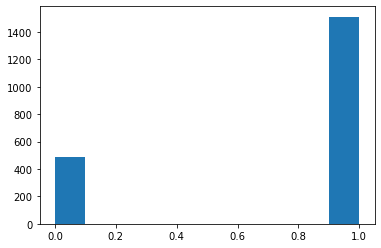

In [11]:
plt.hist(preds.detach().numpy())

#### Genenrate GAN artificial images and save them to compar with original images

In [ ]:
b_size=2000
noise = torch.randn(b_size, nz, 1, 1, device=device)
# Generate fake image batch with G
fake = netG(noise)

# normalize the values
fake=(fake-torch.min(fake))/(torch.max(fake)-torch.min(fake))





counter=0

if not os.path.isdir("GANops/all_imgs/"):
    os.mkdir("GANops/all_imgs/")

print("Saving GAN images")
    
for img in fake:
    loc="GANops/all_imgs/"
#     print("shp is ",img.shape)
    img=img.permute(1,2,0)
#     print("shp is ",img.shape)
    img=img.detach().numpy()
#     print("shp is ",img.shape,np.min(img),np.max(img))  
    if np.min(img)<0 or np.max(img):
        img=(img-np.min(img))/(np.max(img)-np.min(img))
    
    plt.imsave(loc+"img"+str(counter)+".jpeg",img)
#     plt.imshow(img)
#     plt.show()
    counter+=1
    


### artificaial data generated by generator from noise

In [ ]:
b_size=1000
noise = torch.randn(b_size, nz, 1, 1, device=device)
# Generate fake image batch with G
fake = netG(noise)

# normalize the values
fake=(fake-torch.min(fake))/(torch.max(fake)-torch.min(fake))

label = torch.full((b_size,), fake_label, dtype=torch.float, device=device)
# Classify all fake batch with D
output = netD(fake.detach()).view(-1)
# Calculate D's loss on the all-fake batch
errD_fake =  criterion(output, label)

In [ ]:
print("Fake images shape is ",fake.shape)

In [ ]:
errD_fake

In [ ]:
plt.hist(output.detach().numpy())

In [ ]:
torch.min(output),torch.max(output),output.shape

### Test on data generated by VAE using KNNOR

In [6]:
# Let us use the Decoders one by one

#### VAE - Vanilla

In [12]:
model_nm="VanillaVAE"
args_filename="configs/vae.yaml"
with open(args_filename, 'r') as file:
    try:
        config = yaml.safe_load(file)
    except yaml.YAMLError as exc:
        print(exc)
        
model = vae_models[config['model_params']['name']](**config['model_params'])

device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")
chk_path="logs/"+model_nm+"/version_2/checkpoints/last.ckpt"

checkpoint = torch.load(chk_path,map_location=torch.device(device))


for nm,params in model.named_parameters():
#     print(nm)
#     print("model."+nm in checkpoint["state_dict"])
    keyy="model."+nm 
    params.data=checkpoint["state_dict"][keyy]

In [13]:
X_vals_enc_arr=np.load("logs/"+model_nm+"/enc/test_aug_enc.npy")
mid=X_vals_enc_arr.shape[1]//2

with torch.no_grad():
    
    mu=X_vals_enc_arr[:,:mid]
    log_var=X_vals_enc_arr[:,mid:]

    mu=torch.tensor(mu)
    log_var=torch.tensor(log_var)
    print(mu.shape,log_var.shape)
    z = model.reparameterize(mu, log_var)    
    images=model.decode(z)    
    
    

torch.Size([2000, 128]) torch.Size([2000, 128])


In [14]:
print("Images shape is ",images.shape)

Images shape is  torch.Size([2000, 3, 64, 64])


In [15]:
# normalize the values
images=(images-torch.min(images))/(torch.max(images)-torch.min(images))

b_size=images.shape[0]


label = torch.full((b_size,), fake_label, dtype=torch.float, device=device)
# Classify all fake batch with D
output = netD(images.detach()).view(-1)
# Calculate D's loss on the all-fake batch
# errD_fake =  criterion(output, label)

In [16]:

outputs = alex_model(images)
label = torch.full((b_size,), fake_label, dtype=torch.long, device=device)
print(outputs.shape)
criterion = nn.CrossEntropyLoss()
print(label.shape)
_,preds=torch.max(outputs,1)
loss=criterion(outputs,label)

# Calculate D's loss on the all-fake batch
errD_fake =  loss

print("Error or loss is ",errD_fake)
running_corrects = torch.sum(preds == label.data)
acc=running_corrects/labels.shape[0]
print("AlexNet Accuracy is ",acc)

torch.Size([2000, 2])
torch.Size([2000])
Error or loss is  tensor(1.4929, grad_fn=<NllLossBackward>)
AlexNet Accuracy is  tensor(0.0560)


In [17]:
print(errD_fake)

tensor(1.4929, grad_fn=<NllLossBackward>)


(array([ 112.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
        1888.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

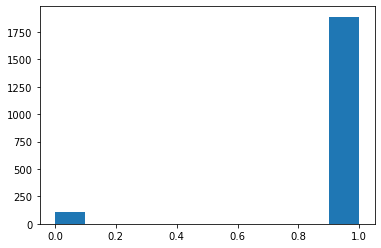

In [20]:
plt.hist(preds.detach().numpy())

### VAE - Vanilla Pruned

In [21]:
model_nm="VanillaVAE"
args_filename="configs/vae.yaml"
with open(args_filename, 'r') as file:
    try:
        config = yaml.safe_load(file)
    except yaml.YAMLError as exc:
        print(exc)
        
model = vae_models[config['model_params']['name']](**config['model_params'])

device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")
chk_path="logs/"+model_nm+"/version_2/checkpoints/last.ckpt"

checkpoint = torch.load(chk_path,map_location=torch.device(device))


for nm,params in model.named_parameters():
#     print(nm)
#     print("model."+nm in checkpoint["state_dict"])
    keyy="model."+nm 
    params.data=checkpoint["state_dict"][keyy]

In [22]:
import lib_prune

In [23]:
state_dicts=[]
epoch_names=["last.ckpt","epoch=2-step=7631.ckpt"]

for epoch_name in epoch_names:
    chk_path="logs/"+model_nm+"/version_2/checkpoints/"+epoch_name
    print(chk_path)
    checkpoint = torch.load(chk_path,map_location=torch.device(device))
    state_dict=checkpoint["state_dict"]
    state_dicts.append(state_dict)
    
importance_vector=[0.8,0.2]
evol_wts={}
for nm,params in model.named_parameters():
    if "weight" in nm and "bn" not in nm and "linear" not in nm:
#         print(nm,params.shape)
        keyy="model."+nm         
#         print(state_dicts[0][keyy].shape,state_dicts[1][keyy].shape)
#         print(state_dicts[0][keyy][0],state_dicts[1][keyy][0])        
        new_param_values=lib_prune.get_weighted_mean(state_dicts,keyy,importance_vector)
#         print(new_param_values[0])
        evol_wts[nm]=new_param_values
    
prune_rate=0.4
print("Generating mask")
list_mask_val=lib_prune.create_mask_from_mean_wt(model,evol_wts,prune_rate)   



model=lib_prune.apply_mask_model(model,list_mask_val)
total_size,nz_size=lib_prune.model_size(model)
compression=(total_size-nz_size)/total_size
print("compression is ",compression)

logs/VanillaVAE/version_2/checkpoints/last.ckpt
logs/VanillaVAE/version_2/checkpoints/epoch=2-step=7631.ckpt
Generating mask
compression is  0.3886396275937206


In [24]:
X_vals_enc_arr=np.load("logs/"+model_nm+"/enc/pruned_"+str(prune_rate)+"_test_aug_enc.npy")

mid=X_vals_enc_arr.shape[1]//2

with torch.no_grad():
    
    mu=X_vals_enc_arr[:,:mid]
    log_var=X_vals_enc_arr[:,mid:]

    mu=torch.tensor(mu)
    log_var=torch.tensor(log_var)
    print(mu.shape,log_var.shape)
    z = model.reparameterize(mu, log_var)    
    images=model.decode(z)    
    
    

torch.Size([2000, 128]) torch.Size([2000, 128])


In [25]:
print("Images shape is ",images.shape)

# normalize the values
images=(images-torch.min(images))/(torch.max(images)-torch.min(images))

b_size=images.shape[0]


# Classify all fake batch with D
label = torch.full((b_size,), fake_label, dtype=torch.long, device=device)
print(outputs.shape)
criterion = nn.CrossEntropyLoss()
print(label.shape)
_,preds=torch.max(outputs,1)
loss=criterion(outputs,label)

# Calculate D's loss on the all-fake batch
errD_fake =  loss

print("Error or loss is ",errD_fake)
running_corrects = torch.sum(preds == label.data)
acc=running_corrects/labels.shape[0]
print("AlexNet Accuracy on prune rate",prune_rate,"compression",compression," is ",acc)

Images shape is  torch.Size([2000, 3, 64, 64])
torch.Size([2000, 2])
torch.Size([2000])
Error or loss is  tensor(1.4929, grad_fn=<NllLossBackward>)
AlexNet Accuracy on prune rate 0.4 compression 0.3886396275937206  is  tensor(0.0560)


(array([ 112.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
        1888.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

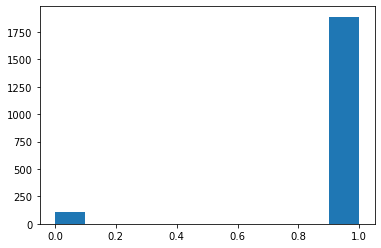

In [26]:
plt.hist(preds.detach().numpy())